# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# get all packages needed 
import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2                
from tqdm import tqdm
from PIL import Image, ImageFile 

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import matplotlib.pyplot as plt                        
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()


################
# import images
################
import numpy as np
from glob import glob


# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


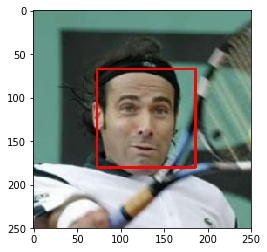

In [2]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.imread(human_files[1])

def test_face_detector(img, face_detector):
    # convert BGR image to grayscale
    gray = convertToRGB(img)

    # find faces in image
    faces = face_detector.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y-4),(x+w+4,y+h),(0,0,255),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

test_face_detector(img, face_cascade) 

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = convertToRGB(img)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
See comment below.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## Testing the performance of the face_detector algorithm on the images in human_files_short and dog_files_short.
Fcs_Dtctd_Frm_Faces = [face_detector(face) for face in tqdm(human_files_short, desc='Humans')]
Fcs_Dtctd_Frm_Dogs = [face_detector(face) for face in tqdm(dog_files_short, desc='Dogs')]

print(f'{sum(Fcs_Dtctd_Frm_Faces) / len(human_files_short) * 100:4.1f}% of humans faces correctly classified')
print(f'{sum(Fcs_Dtctd_Frm_Dogs) / len(dog_files_short) * 100:4.1f}% of dogs missclassified as human faces')


#############################################
# 96.0% of humans faces correctly classified
# 16.0% of dogs missclassified as human faces
#############################################

Dogs: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s]

96.0% of humans faces correctly classified
16.0% of dogs missclassified as human faces


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

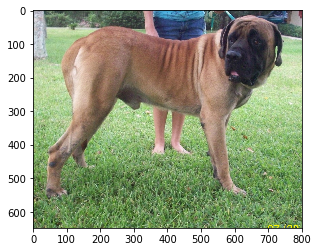

torch.Size([1, 3, 224, 224])
Predicted class : 243


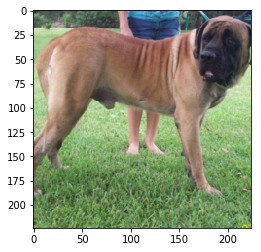

In [7]:
def image_to_tensor(img_path):
    '''
    From Pytorch docs: All pre-trained models expect input images normalized
    in the same way as i.e. mini-batches of 3-channel RGB images of shape 
    (3 x H x W), where both H and W are expected to >= 224. 
    Images have to be loaded in to a range of [0, 1] and 
    then normalized using mean = [0.485, 0.456, 0.406] and 
    std = [0.229, 0.224, 0.225]. 
    '''
    
    #You can use the following transform to normalize:
    img = Image.open(img_path).convert('RGB')
    trsfrmtns = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = trsfrmtns(img)[:3,:,:].unsqueeze(0)
    return image_tensor


# helper function for un-normalizing an image and converting it
# from a Tensor image to a NumPy image for display

def im_convert(tensor):
    # Display a tensor as an image.
    img = tensor.to("cpu").clone().detach()
    img = img.numpy().squeeze()
    img = img.transpose(1,2,0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img = img.clip(0, 1)

    return img

## test functions above on first of dog images
dog_image = Image.open(dog_files[0])
plt.imshow(dog_image)
plt.show()

test_tensor = image_to_tensor(dog_files[0])
# print(test_tensor)
print(test_tensor.shape)
plt.imshow(im_convert(test_tensor))


## Fucntion to Load and pre-process an image from the given img_path
## Return the *index* of the predicted class for that image

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image_tensor = image_to_tensor(img_path)
   
    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = VGG16(image_tensor)
    # convert output probabilities to predicted class
#    _, preds_tensor = torch.max(output, 1)
#    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 
    pred = torch.argmax(output).item()
    return int(pred)    
    
test_prediction = VGG16_predict(dog_files[0])
        
print(f"Predicted class : {test_prediction}")




### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    idx = VGG16_predict(img_path)
    # Note: acceptable "dog" values should be between 151 and 268 included
    return 151 <= idx <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
See comment below.

In [9]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

Dgs_Dtctd_Frm_Faces = 0
Dgs_Dtctd_Frm_Dogs = 0

for ii in range(100):
    if dog_detector(human_files_short[ii]):
        Dgs_Dtctd_Frm_Faces += 1
    if dog_detector(dog_files_short[ii]):
        Dgs_Dtctd_Frm_Dogs +=1
        
print('#### VGG16 ####')
print (f"Percentage of the images in human_files_short that have a detected dog: {Dgs_Dtctd_Frm_Faces}%")
print (f"Percentage of the images in dog_files_short that have a detected dog: {Dgs_Dtctd_Frm_Dogs}%")

#############################################
# Wrong human detections (in dog pics): 0%
# Correct dog detections (in dog pics): 100%
#############################################

#### VGG16 ####
Percentage of the images in human_files_short that have a detected dog: 1%
Percentage of the images in dog_files_short that have a detected dog: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

Number of classes: 133


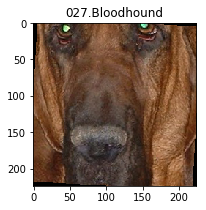

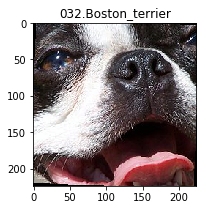

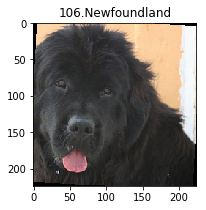

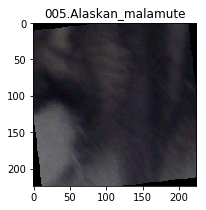

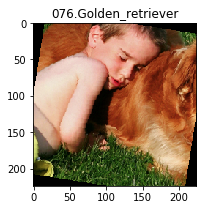

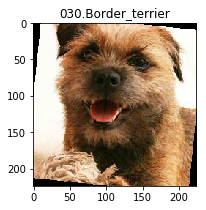

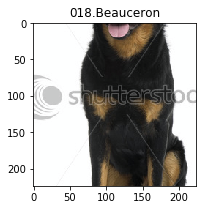

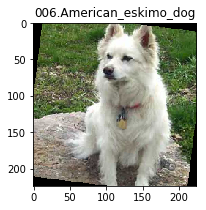

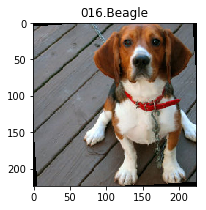

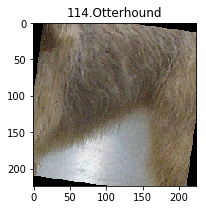

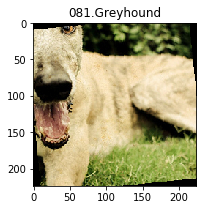

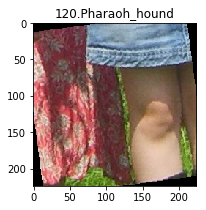

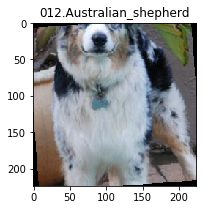

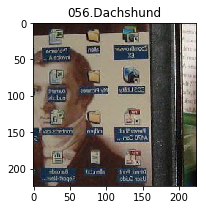

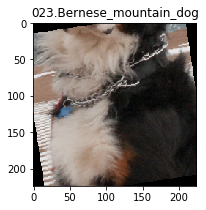

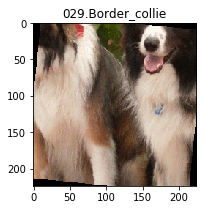

In [11]:
# make sure to have necessary packages for step
import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2                
from tqdm import tqdm
from PIL import Image, ImageFile 

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import matplotlib.pyplot as plt                        
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()


################################################################
# Data loaders for training, validation, and test sets
################################################################

# how many samples per batch to load
batch_size = 16

# number of subprocesses to use for data loading
num_workers = 2

# convert data to a normalized torch.FloatTensor
transform = {'train': transforms.Compose([transforms.CenterCrop((224,224)),
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
             'valid': transforms.Compose([transforms.CenterCrop((224,224)),
                                transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
             'test': transforms.Compose([transforms.CenterCrop((224,224)),
                                transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
            }
# define training, test and validation data directories
Dat_Drc = '/data/dog_images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(Dat_Drc, x), transform[x])
                  for x in ['train', 'valid', 'test']}
loaders_scratch = {
    x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=num_workers)
    for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes
nb_classes = len(class_names)

print("Number of classes:", nb_classes)

# Get a batch of training data
inputs, classes = next(iter(loaders_scratch['train']))

for img, lbl in zip(inputs, classes): 
    img = img.to("cpu").clone().detach()
    img = img.numpy().squeeze()
    img = img.transpose(1,2,0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img = img.clip(0, 1)
     
    fig = plt.figure(figsize=(12,3))
    plt.imshow(img)
    plt.title(class_names[lbl])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
First I resized all image to 224.

Ideally we want randomness in the data to prevent overfitting.  This can be achieved with augmentation of the dataset, to extend a dataset and improve generalization when training the model.
I then decided to apply a RandomHorizontalFlip & RandomRotation to achieve augmentation of the datasets. 
 
Finally, one needs to consider the requirements of pretrained CNNs. Most of the pretrained models require the input to be 224x224 images, so I applied a CenterCrop to that size. Similarly, normalization used when the models were trained needs to be matched (using means [0.485, 0.456, 0.406] and the standard deviations [0.229, 0.224, 0.225]).

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
 # define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # linear layer (500 -> 133) as required
        self.fc2 = nn.Linear(500, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.batch_norm = nn.BatchNorm1d(num_features=500)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))       
        # add dropout layer
        x = self.dropout(x)        
        x = self.pool(F.relu(self.conv2(x)))        
        # add dropout layer
        x = self.dropout(x)        
        x = self.pool(F.relu(self.conv3(x)))
        # add dropout layer
        x = self.dropout(x)        
        # flatten image input
        # 64 * 28 * 28         
        x = x.view(x.size(0), -1)      
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.batch_norm(self.fc1(x)))       
        # add dropout layer
        x = self.dropout(x)        
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# initiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
I created the CNN starting from the first layer (with input input shape of (224, 224, 3)) and the last layer (needed to output 133 classes), in order to match the requirements.

I started adding convolutional layers (stack of filtered images) and maxpooling layers (to downsample, keeping only the most active pixels from the previous layer), together with the usual Linear/Dropout layers to avoid overfitting and produce the an output of the required size (133).

The more convolutional layers we include, the more complex patterns in color and shape a model can detect, although one needs to be aware of potential overfitting (hence the use of a dropout layer at the end).

I chose to have 3 convolutional layers with a kernel size of 3x3 and a padding of 1, which gradually increases the number of feature maps, but keeps the size consistent.
I wanted my first layer to have 16 filters, each with a height and width of 3. When performing the convolution, I'd like the filter to jump 1 pixel at a time (Stride values). I also want this layer to have the same width and height as the input layer (padding is on).

From examples of similar classification problems, MaxPooling2D seems to be a common choice to downsample. In between every convolutional layer, there is a maxpool layer with a 2x2 kernel and a stride of 2 which halfs the size of all featuremaps. 

Then the feature maps are flattened to a vector of length 500. Before feeding the fully connected (FC) layers for classification, I added a fully connected Linear Layer to produce a 133-dim output as needed. 
I am adding a fully connected Linear Layer to produce a 133-dim output. 

Finally, considering the potential risk of overfitting, I added a Dropout layer.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    
    valid_loss_min = np.Inf
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()    
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

# Train the model
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.734706 	Validation Loss: 4.814694
Validation loss decreased (inf --> 4.814694).  Saving model ...
Epoch: 2 	Training Loss: 4.522141 	Validation Loss: 4.782794
Validation loss decreased (4.814694 --> 4.782794).  Saving model ...
Epoch: 3 	Training Loss: 4.411973 	Validation Loss: 4.793244
Epoch: 4 	Training Loss: 4.325486 	Validation Loss: 4.761543
Validation loss decreased (4.782794 --> 4.761543).  Saving model ...
Epoch: 5 	Training Loss: 4.247194 	Validation Loss: 4.758645
Validation loss decreased (4.761543 --> 4.758645).  Saving model ...
Epoch: 6 	Training Loss: 4.183152 	Validation Loss: 4.731434
Validation loss decreased (4.758645 --> 4.731434).  Saving model ...
Epoch: 7 	Training Loss: 4.110199 	Validation Loss: 4.732102
Epoch: 8 	Training Loss: 4.034628 	Validation Loss: 4.616188
Validation loss decreased (4.731434 --> 4.616188).  Saving model ...
Epoch: 9 	Training Loss: 3.969243 	Validation Loss: 4.475618
Validation loss decreased (4.616188 --> 4.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [15]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
          # update average test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    # print testing statistics 
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    
###
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

#############################################
# RESULTS: accuracy 11% > 10% required
#############################################

Test Loss: 3324.749147


Test Accuracy: 11% (100/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [16]:
## Specify data loaders -> use the same one as created above
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
# Model architecture 
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# download resnet50 pretrained model
# NOTE it gave better results than using VGG16
# See comments for setup adjustments below
model_transfer =  models.resnet50(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

# Freeze parameters to avoid backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
    
# Replace the last fully connected layer with a Linnear layer with 133 out features
model_transfer.fc = nn.Linear(2048, 133)
if use_cuda:
    model_transfer = model_transfer.cuda()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 84355712.23it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

As mentioned above, one can find CNN along with weights that have been pre-trained on ImageNet to achieve high accuracy. One can then use transfer learning to apply the trained network to the task of interest.

I first tried to use the original VGS16 to initiate the network, but was struggling to get satisfying accuracy. I then considered the resnet50 CNN mentioned above and achieve better results.

My CNN is a single fully-connected layer:

    (fc): Linear(in_features=2048, out_features=1000, bias=True)

This layer would not work directly for the dog classification problem as it was trained on the ImageNet dataset. First, one needs to change the number of nodes of the fully connected layer to match the number of dog classes we have, i.e. 133. Once one replaces the classifier (to 133 classes), all the other features will work.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [18]:
criterion_transfer = nn.CrossEntropyLoss()

# Note: only need to train the classifier--> model_transfer.classifier.parameters()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [19]:
# train the model: reuse train function defined in previous step
model_transfer =  train(15, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# loading the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.900142 	Validation Loss: 1.374716
Validation loss decreased (inf --> 1.374716).  Saving model ...
Epoch: 2 	Training Loss: 1.556497 	Validation Loss: 1.198074
Validation loss decreased (1.374716 --> 1.198074).  Saving model ...
Epoch: 3 	Training Loss: 1.328385 	Validation Loss: 1.165002
Validation loss decreased (1.198074 --> 1.165002).  Saving model ...
Epoch: 4 	Training Loss: 1.200413 	Validation Loss: 1.235460
Epoch: 5 	Training Loss: 1.090406 	Validation Loss: 1.122537
Validation loss decreased (1.165002 --> 1.122537).  Saving model ...
Epoch: 6 	Training Loss: 1.009399 	Validation Loss: 1.076492
Validation loss decreased (1.122537 --> 1.076492).  Saving model ...
Epoch: 7 	Training Loss: 0.971311 	Validation Loss: 1.134974
Epoch: 8 	Training Loss: 0.909773 	Validation Loss: 1.191053
Epoch: 9 	Training Loss: 0.909323 	Validation Loss: 1.129674
Epoch: 10 	Training Loss: 0.842166 	Validation Loss: 1.198937
Epoch: 11 	Training Loss: 0.831022 	Validation Lo

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [20]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

#############################################
# RESULTS: test accuracy 67% > 60% required
#############################################

Test Loss: 959.053129


Test Accuracy: 67% (563/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [21]:
### Function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = image_to_tensor(img_path)

    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [22]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
        print('This is just a person, but....')
        plt.imshow(Image.open(img_path))
        plt.show()
        print(f'if they were a dog, they would be a: {predict_breed_transfer(img_path)}')
        print('\n_____________________________________\n')
    elif dog_detector(img_path):
        plt.imshow(Image.open(img_path))
        plt.show()
        print(f'This dog should be a: {predict_breed_transfer(img_path)}')
        print('\n_____________________________________\n')
    else:
        plt.imshow(Image.open(img_path))
        plt.show()
        print('Sorry, this photo does not seem to have a human or a dog.')
        print('\n_____________________________________\n')


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__

The class seemed to perform pretty well (accuracy >80%) although would have preferred the accuracy to exceed 90%.

Possible considerations for improvement:
- Fine tune the models to give a better accuracy >= 90%;
- Implement my own face detector (possibly using transfer learning);
- Ability to handle the case when there are multiple dogs/humans or a mix of humans and dogs in an image (e.g. in the cartoon with the Lady and the tramp below);
- Systematically compare different models, opimizers and loss functions;
- Investigate the effect of image resolution (size) on prediction performance.


This is just a person, but....


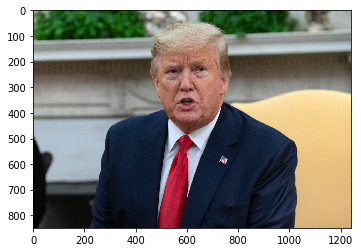

if they were a dog, they would be a: Field spaniel

_____________________________________

This is just a person, but....


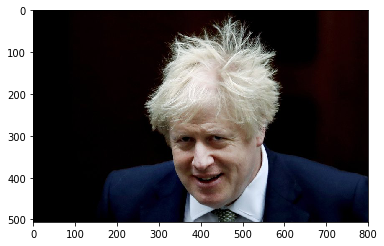

if they were a dog, they would be a: Bedlington terrier

_____________________________________

This is just a person, but....


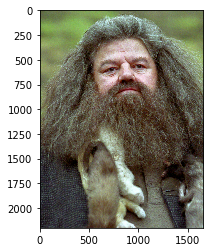

if they were a dog, they would be a: Komondor

_____________________________________



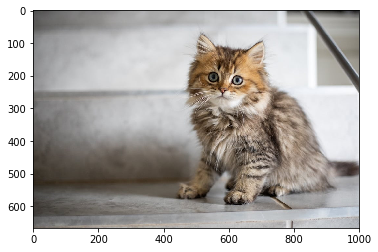

Sorry, this photo does not seem to have a human or a dog.

_____________________________________



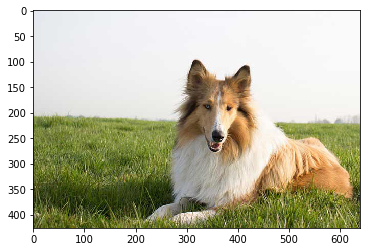

This dog should be a: Collie

_____________________________________



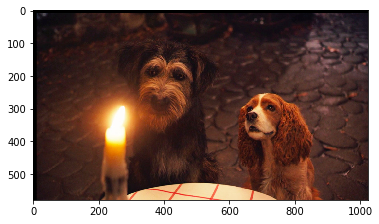

This dog should be a: Dachshund

_____________________________________



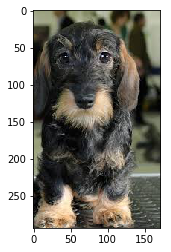

This dog should be a: Dachshund

_____________________________________



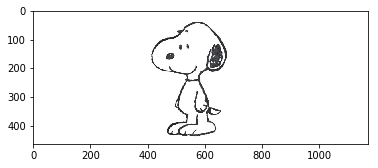

Sorry, this photo does not seem to have a human or a dog.

_____________________________________



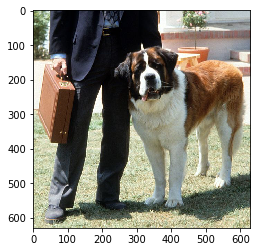

This dog should be a: Saint bernard

_____________________________________



In [23]:
import numpy as np
from glob import glob

# load filenames
files = np.array(glob("my_images/*"))
for file_path in files:
    run_app(file_path)